In [27]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score

from google.colab import drive
drive.mount('/content/gdrive')
root_folder = "/content/gdrive/"

project_folder = root_folder + "/My Drive/epigame-folder/game_vKarla/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
conn_measures = ['PAC', 'SCR-(0,4)', 'SCI-(0,4)', 'PLV-(0,4)', 'PLI-(0,4)', 'CC-(0,4)', 'SCR-(4,8)', 'SCI-(4,8)', 'PLV-(4,8)', 'PLI-(4,8)', 'CC-(4,8)', 'SCR-(8,13)', 'SCI-(8,13)', 'PLV-(8,13)', 'PLI-(8,13)', 'CC-(8,13)', 'SCR-(13,30)', 'SCI-(13,30)', 'PLV-(13,30)', 'PLI-(13,30)', 'CC-(13,30)', 'SCR-(30,70)', 'SCI-(30,70)', 'PLV-(30,70)', 'PLI-(30,70)', 'CC-(30,70)', 'SCR-(70,150)', 'SCI-(70,150)', 'PLV-(70,150)', 'PLI-(70,150)', 'CC-(70,150)']

In [3]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "0,4": "δ",
    "4,8": "ϴ",
    "8,13": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
cm_subs = {
    "SCR-": "Real spectral coherence",
    "SCI-": "Imaginary spectral coherence",
    "PLV-": "Phase-locking value",
    "PLI-": "Phase lag index",
    "CC-": "Cross-correlation",
    "PAC-": "PAC",
    "PEC-": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)',s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace('-','').replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC-(30,70), SCR-(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print(output_str)


CC (low γ), SCR (high γ)


The code below checks if there are any zero Mean_overlap_ratio in the data. If yes, it fetches the value from the same index in the previous sigma file (sigma-1) and continues with the analysis. If a zero is found in row `zero_row_index` in the current sigma file, it replaces the corresponding value with the one from the previous sigma file.


In [8]:
load_data_ori = None

sigma = 4
while sigma > 0:
    load_data_ori = pd.read_excel(project_folder + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

    # Check if "Mean_overlap_ratio" contains any zeros
    zero_row_indices = load_data_ori.index[load_data_ori["Mean_overlap_ratio"] == 0].tolist()

    if zero_row_indices:
        print(f"Zeros found in rows {zero_row_indices} for sigma={sigma}")
        if sigma == 1:
            print("Skipping iteration for sigma=1 with zeros")
            break

        sigma -= 1
        prev_load_data_ori = pd.read_excel(project_folder + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

        for zero_row_index in zero_row_indices:
            zero_value = prev_load_data_ori.loc[zero_row_index, "Mean_overlap_ratio"]
            load_data_ori.loc[zero_row_index, "Mean_overlap_ratio"] = zero_value
    else:
        break  # No zeros found, exit the loop

Zeros found in rows [100, 101, 103, 104, 107, 108, 110, 113, 115, 118, 119, 121, 122, 123, 149, 154, 248, 253, 254, 256, 257, 258, 259, 261, 263, 268, 273, 278, 295, 403, 407, 408, 409, 410, 412, 413, 415, 422, 423, 427, 428, 429, 431, 432, 433, 439, 440, 454, 558, 566, 568, 569, 570, 572, 573, 576, 578, 579, 580, 581, 583, 584, 588, 599, 600, 606, 609, 665, 714, 721, 730, 732, 734, 736, 737, 741, 742, 743, 754, 765, 766, 814, 853, 857, 860, 868, 869, 870, 872, 873, 874, 875, 876, 877, 878, 879, 881, 882, 883, 884, 885, 886, 888, 889, 890, 892, 893, 894, 895, 897, 898, 902, 907, 908, 909, 916, 919, 920, 925, 929, 1023, 1029, 1030, 1033, 1034, 1036, 1038, 1040, 1043, 1048, 1051, 1052, 1053, 1178, 1180, 1185, 1187, 1188, 1193, 1195, 1196, 1198, 1199, 1201, 1202, 1203, 1204, 1206, 1208, 1234, 1236, 1239, 1297, 1333, 1339, 1341, 1343, 1348, 1353, 1358, 1359, 1360, 1363, 1385, 1495, 1496, 1497, 1498, 1503, 1505, 1510, 1512, 1513, 1514, 1515, 1517, 1518, 1530, 1533, 1643, 1645, 1648, 1649, 1

In [10]:
# Function for generating box pairs that will be compared using a statistical test
def generate_box_pairs(method):
  return [(("{}".format(method), 1), ("{}".format(method), 0))]

Sensitivity: 0.7142857142857143 Specificity: 1.0


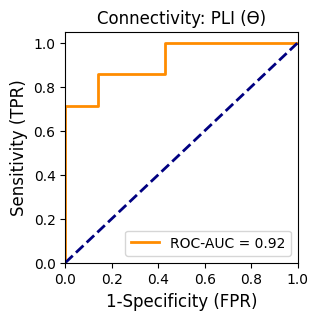

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(4,8)', 1), ('PLI-(4,8)', 0)) stat=9.00e+01 p-value=1.14e-03
pvalues: [0.0011351909184726522]


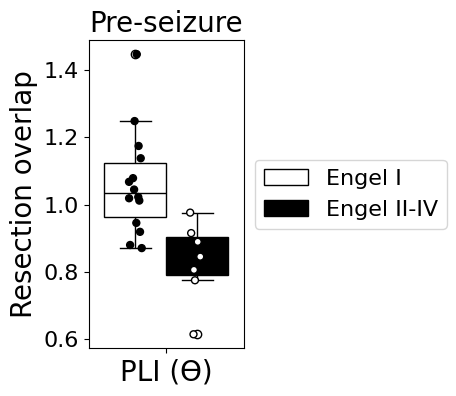

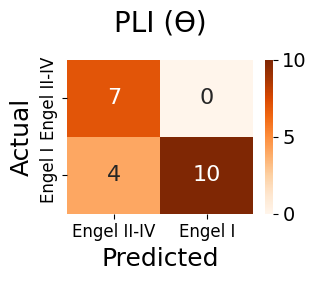

AUC: 0.92
Optimal threshold (Youden's J): 1.01
Sensitivity: 0.71
Specificity: 1.00
F1 Score: 0.83
Misclassified Good keys: [1125, 1280, 1900, 2210]
Misclassified Poor keys: []


In [54]:
load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

# Loop through each connectivity measure
for cm in conn_measures:
    # Group the data by method and get the group for the current connectivity measure
    data = load_data.groupby("CM").get_group(cm)
    scores, actual_labels = list(data.Mean_overlap_ratio), list(data.Outcome)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(actual_labels, scores)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Compute Youden's index
    youden_index = tpr - fpr
    best_threshold_index = np.argmax(youden_index)

    # Sensitivity and specificity at the best threshold
    sens = tpr[best_threshold_index]
    spec = 1 - fpr[best_threshold_index]

    # Append the results to the list
    results.append({
        'CM': cm,
        'AUC': roc_auc,
        'Sensitivity': sens,
        'Specificity': spec
    })
    cm_str = substitute_cm(substitute_bands(cm))

    # Plot the ROC curve if AUC > 0.8
    if roc_auc > 0.8: # Remove of modify this logic to print all/specific ROC curves
        print('Sensitivity:', sens,
        'Specificity:', spec)
        plt.figure(figsize=(3, 3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        box_pairs = generate_box_pairs(cm)

        test_short_name = 'MannWhitneyU Two-sided'

        pvalues=[]
        for pair in box_pairs:

            data1 = data.groupby("CM").get_group(pair[0][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[0][1])
            data2 = data.groupby("CM").get_group(pair[1][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[1][1])

            stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
            print("Performing %s statistical test for equal variances on pair:"%test_short_name, pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
            pvalues.append(p)
        print("pvalues:", pvalues)

        palette_box = {1:"white", 0:"black"}
        palette_strip = {0:"white", 1:"black"}
        plt.figure(figsize=(2,4))

        bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=data, palette=palette_box, hue="Outcome", hue_order=[1,0])
        bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=data, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

        handles, labels = bp.get_legend_handles_labels()
        plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Pre-seizure", size=20)
        plt.yticks(fontsize=16)
        plt.xticks([0], [cm_str], fontsize=20)
        plt.ylabel("Resection overlap", fontsize=20)
        plt.xlabel('')
        # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
        #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

        plt.show()
        # plt.savefig("D:/%s.png"%t)
        plt.close()

        # Make confusion matrix
        good_scores = data1
        poor_scores = data2
        # Combine scores into a single DataFrame
        all_scores = {**good_scores, **poor_scores}
        labels = {k: 'good' for k in good_scores}
        labels.update({k: 'poor' for k in poor_scores})

        j_scores = tpr - fpr
        j_ordered = sorted(zip(j_scores, thresholds))
        optimal_threshold = j_ordered[-1][1]

        df = pd.DataFrame(list(all_scores.items()), columns=['index', 'score'])
        df['label'] = df['score'].map(labels)
        df['label'] = df['label'].map({'good': 1, 'poor': 0})

        df['pred'] = (df['score'] >= optimal_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(df['label'], df['pred']).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate the F1 score at Youden's J threshold
        f1 = f1_score(df['label'], df['pred'])
        # Compute the confusion matrix
        cm = confusion_matrix(df['label'], df['pred'])

        # Visualize the confusion matrix
        plt.figure(figsize=(3,2))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', annot_kws={"size": 16}, xticklabels=['Engel II-IV', 'Engel I'], yticklabels=['Engel II-IV', 'Engel I'])
        plt.xlabel('Predicted', size=18)
        plt.ylabel('Actual', size=18)
        plt.title(f'{cm_str}', size=20, pad=20)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        plt.show()
        # Find misclassified keys
        misclassified_good = df[(df['label'] == 1) & (df['pred'] == 0)]['index'].tolist()
        misclassified_poor = df[(df['label'] == 0) & (df['pred'] == 1)]['index'].tolist()

        # Print the AUC, optimal threshold, specificity, sensitivity, and F1 score
        print(f'AUC: {roc_auc:.2f}')
        print(f'Optimal threshold (Youden\'s J): {optimal_threshold:.2f}')
        print(f'Sensitivity: {sensitivity:.2f}')
        print(f'Specificity: {specificity:.2f}')
        print(f'F1 Score: {f1:.2f}')
        # Print misclassified keys
        print(f'Misclassified Good keys: {misclassified_good}')
        print(f'Misclassified Poor keys: {misclassified_poor}')


# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "1cm_rocauc_results.xlsx", index=False)

In [41]:
# Function to compute AUC, sensitivity, and specificity for a given combination of connectivity measures
def compute_metrics_for_combination(cm_combination, load_data, n_subjects=21):

    combined_scores = []
    actual_labels = None

    for cm in cm_combination:

        data = load_data[load_data['CM'] == cm]
        if data['Mean_overlap_ratio'].values.shape[0] == n_subjects:
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
        else: break

    if len(combined_scores) == len(cm_combination):

      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      roc_auc = auc(fpr, tpr)

      # Compute Youden's index
      youden_index = tpr - fpr
      best_threshold_index = np.argmax(youden_index)

      # Sensitivity and specificity at the best threshold
      sens = tpr[best_threshold_index]
      spec = 1 - fpr[best_threshold_index]

      return roc_auc, sens, spec

    else: return None, None, None

In [ ]:
# Generate combinations of 2 connectivity measures

results = []

load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

for cm_combination in itertools.combinations(conn_measures, 2):

    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      combination_str = ', '.join(cm_combination)
      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve

      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, _ = roc_curve(actual_labels, avg_scores)
      cm_str = substitute_bands(substitute_cm(combination_str))

      if roc_auc > 0.8:

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        df_plot = pd.DataFrame({'Mean_overlap_ratio':avg_scores,
            'CM':cm_str,
            'Outcome':list(data['Outcome'])})

        palette_box = {1:"white", 0:"black"}
        palette_strip = {0:"white", 1:"black"}
        plt.figure(figsize=(2,4))

        bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=df_plot, palette=palette_box, hue="Outcome", hue_order=[1,0])
        bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=df_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

        handles, labels = bp.get_legend_handles_labels()
        plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Pre-seizure", size=20)
        plt.yticks(fontsize=16)
        plt.xticks([0], [cm_str], fontsize=20)
        plt.ylabel("Resection overlap", fontsize=20)
        plt.xlabel('')
        # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
        #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

        plt.show()
        # plt.savefig("D:/%s.png"%t)
        plt.close()
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "2cm_rocauc_results.xlsx", index=False)

In [ ]:
# Generate combinations of 3 connectivity measures

load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

for cm_combination in itertools.combinations(conn_measures, 3):
    combination_str = ', '.join(cm_combination)
    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve
      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, _ = roc_curve(actual_labels, avg_scores)
      cm_str = substitute_bands(substitute_cm(combination_str))

      if roc_auc > 0.95:

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        df_plot = pd.DataFrame({'Mean_overlap_ratio':avg_scores,
            'CM':cm_str,
            'Outcome':list(data['Outcome'])})

        palette_box = {1:"white", 0:"black"}
        palette_strip = {0:"white", 1:"black"}
        plt.figure(figsize=(2,4))

        bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=df_plot, palette=palette_box, hue="Outcome", hue_order=[1,0])
        bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=df_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

        handles, labels = bp.get_legend_handles_labels()
        plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Pre-seizure", size=20)
        plt.yticks(fontsize=16)
        plt.xticks([0], [cm_str], fontsize=20)
        plt.ylabel("Resection overlap", fontsize=20)
        plt.xlabel('')
        # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
        #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

        plt.show()
        # plt.savefig("D:/%s.png"%t)
        plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "3cm_rocauc_results.xlsx", index=False)

In [42]:
# conn_measures = ['PLV-(0,4)', 'PLI-(4,8)', 'SCI-(30,70)', 'SCR-(0,4)']

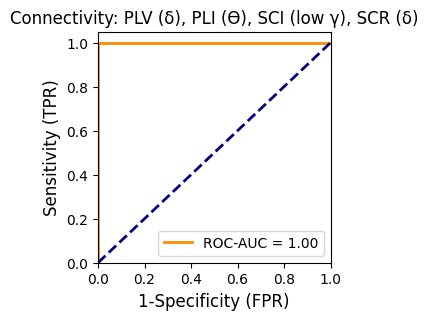

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV (δ), PLI (ϴ), SCI (low γ), SCR (δ)', 1), ('PLV (δ), PLI (ϴ), SCI (low γ), SCR (δ)', 0)) stat=9.80e+01 p-value=1.72e-05
pvalues: [1.719986240110079e-05]


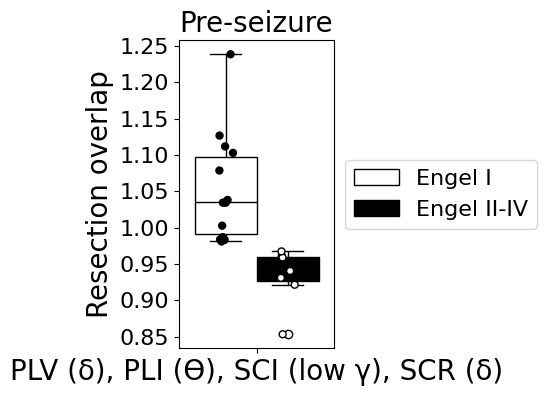

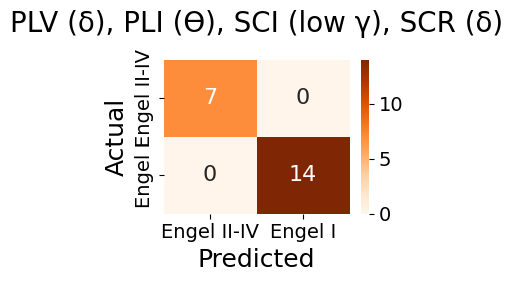

AUC: 1.00
Optimal threshold (Youden's J): 0.98
Sensitivity: 1.00
Specificity: 1.00
F1 Score: 1.00
Misclassified Good keys: []
Misclassified Poor keys: []


In [53]:
# Generate combinations of 4 connectivity measures
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

for cm_combination in itertools.combinations(conn_measures, 4):
    combination_str = ', '.join(cm_combination)
    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve
      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      cm_str = substitute_bands(substitute_cm(combination_str))

      if roc_auc > 0.99:

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        df_plot = pd.DataFrame({'Mean_overlap_ratio':avg_scores,
            'CM':cm_str,
            'Outcome':list(data['Outcome'])})

        box_pairs = generate_box_pairs(cm_str)

        test_short_name = 'MannWhitneyU Two-sided'

        pvalues = []
        data1, data2 = 0,0
        for pair in box_pairs:

            data1 = df_plot.groupby("CM").get_group(pair[0][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[0][1])
            data2 = df_plot.groupby("CM").get_group(pair[1][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[1][1])

            stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
            print("Performing %s statistical test for equal variances on pair:"%test_short_name, pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
            pvalues.append(p)
        print("pvalues:", pvalues)

        palette_box = {1:"white", 0:"black"}
        palette_strip = {0:"white", 1:"black"}
        plt.figure(figsize=(2,4))

        bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=df_plot, palette=palette_box, hue="Outcome", hue_order=[1,0])
        bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=df_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

        handles, labels = bp.get_legend_handles_labels()
        plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Pre-seizure", size=20)
        plt.yticks(fontsize=16)
        plt.xticks([0], [cm_str], fontsize=20)
        plt.ylabel("Resection overlap", fontsize=20)
        plt.xlabel('')
        # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
        #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

        plt.show()
        # plt.savefig("D:/%s.png"%t)
        plt.close()
        # Make confusion matrix
        good_scores = data1
        poor_scores = data2
        # Combine scores into a single DataFrame
        all_scores = {**good_scores, **poor_scores}
        labels = {k: 'good' for k in good_scores}
        labels.update({k: 'poor' for k in poor_scores})

        j_scores = tpr - fpr
        j_ordered = sorted(zip(j_scores, thresholds))
        optimal_threshold = j_ordered[-1][1]

        df = pd.DataFrame(list(all_scores.items()), columns=['index', 'score'])
        df['label'] = df['score'].map(labels)
        df['label'] = df['label'].map({'good': 1, 'poor': 0})

        df['pred'] = (df['score'] >= optimal_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(df['label'], df['pred']).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate the F1 score at Youden's J threshold
        f1 = f1_score(df['label'], df['pred'])
        # Compute the confusion matrix
        cm = confusion_matrix(df['label'], df['pred'])

        # Visualize the confusion matrix
        plt.figure(figsize=(3,2))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', annot_kws={"size": 16}, xticklabels=['Engel II-IV', 'Engel I'], yticklabels=['Engel II-IV', 'Engel I'])
        plt.xlabel('Predicted', size=18)
        plt.ylabel('Actual', size=18)
        plt.title(f'{cm_str}', size=20, pad=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        plt.show()
        # Find misclassified keys
        misclassified_good = df[(df['label'] == 1) & (df['pred'] == 0)]['index'].tolist()
        misclassified_poor = df[(df['label'] == 0) & (df['pred'] == 1)]['index'].tolist()

        # Print the AUC, optimal threshold, specificity, sensitivity, and F1 score
        print(f'AUC: {roc_auc:.2f}')
        print(f'Optimal threshold (Youden\'s J): {optimal_threshold:.2f}')
        print(f'Sensitivity: {sensitivity:.2f}')
        print(f'Specificity: {specificity:.2f}')
        print(f'F1 Score: {f1:.2f}')
        # Print misclassified keys
        print(f'Misclassified Good keys: {misclassified_good}')
        print(f'Misclassified Poor keys: {misclassified_poor}')

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "4cm_rocauc_results.xlsx", index=False)

In [57]:
load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

N_comb = 8

for cm_combination in itertools.combinations(conn_measures, N_comb):
    combination_str = ', '.join(cm_combination)
    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve
      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      cm_str = substitute_bands(substitute_cm(combination_str))

      if roc_auc > 0.99:

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        df_plot = pd.DataFrame({'Mean_overlap_ratio':avg_scores,
            'CM':cm_str,
            'Outcome':list(data['Outcome'])})

        box_pairs = generate_box_pairs(cm_str)

        test_short_name = 'MannWhitneyU Two-sided'

        pvalues = []
        data1, data2 = 0,0
        for pair in box_pairs:

            data1 = df_plot.groupby("CM").get_group(pair[0][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[0][1])
            data2 = df_plot.groupby("CM").get_group(pair[1][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[1][1])

            stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
            print("Performing %s statistical test for equal variances on pair:"%test_short_name, pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
            pvalues.append(p)
        print("pvalues:", pvalues)

        palette_box = {1:"white", 0:"black"}
        palette_strip = {0:"white", 1:"black"}
        plt.figure(figsize=(2,4))

        bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=df_plot, palette=palette_box, hue="Outcome", hue_order=[1,0])
        bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=df_plot, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

        handles, labels = bp.get_legend_handles_labels()
        plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.title("Pre-seizure", size=20)
        plt.yticks(fontsize=16)
        plt.xticks([0], [cm_str], fontsize=20)
        plt.ylabel("Resection overlap", fontsize=20)
        plt.xlabel('')
        # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
        #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

        plt.show()
        # plt.savefig("D:/%s.png"%t)
        plt.close()


# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + f"{N_comb}cm_rocauc_results.xlsx", index=False)

KeyboardInterrupt: 